Interactive plot of all ColdFusion data

First, the set up and imports

In [22]:
!pip install basemap
# Imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas
from snowexsql.db import get_table_attributes

import datetime
from sqlalchemy import inspect
from sqlalchemy.sql import func
import shapely.geometry
from geoalchemy2.shape import from_shape
import geoalchemy2.functions as gfunc
from geoalchemy2.types import Raster

# Imports for Lidar raster
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

# some mapping widgets
import ipyleaflet
from ipyleaflet import Map, GeoData, Rectangle, basemaps, LayersControl, basemap_to_tiles, TileLayer, SplitMapControl, Polygon, MagnifyingGlass
import ipywidgets

# interactive plots
import holoviews as hv
import geoviews as gv
import hvplot.pandas
import hvplot.xarray
# set bokeh as the holoviews plotting backend
#hv.extension('bokeh')
# set holoviews backend to Bokeh
#gv.extension('bokeh')

# used to find nearest grid cell to a given location
from scipy.spatial import distance

import fsspec
from datetime import datetime as dt

from geoviews import opts
from geoviews import tile_sources as gvts
from datashader.colors import viridis
import datashader
from holoviews.operation.datashader import datashade, shade, dynspread, spread, rasterize
from holoviews.streams import Selection1D, Params
import panel as pn
import param as pm
import warnings
import holoviews.operation.datashader as hd
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")



from rasterio.plot import show
import shapely.geometry

from geoalchemy2.shape import from_shape
import geoalchemy2.functions as gfunc
import rioxarray
import rasterio

# load the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

In [24]:
# database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas, raster_to_rasterio
from snowexsql.db import get_table_attributes

Bounding box and dates

In [4]:
# How to pull out ALL point data from the database that falls within our box
bbox_WSEN = 742000, 4322000, 747000, 4325000 # EPSG 26912?
x1, y1, x2, y2 = bbox_WSEN
polygon = shapely.geometry.Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]]) # used box() before
wkb_element = from_shape(polygon, srid=26912) # which srid is right?

# Desired Magnaprobe sample dates 
depth1_date1 = datetime.date(2020,2,1) # Corresponds to ASO flight on 2/2/2020 (lidar1)
depth2_date1 = datetime.date(2020,2,12) # Corresponds to ASO flight on 2/13/2020 (lidar1)

# Desired snow pit sample dates 
density1_date1 = datetime.date(2020,1,28)
density1_date2 = datetime.date(2020,2,2) 

density2_date1 = datetime.date(2020,2,4)
density2_date2 = datetime.date(2020,2,13) 

Magnaprobe data

In [5]:
# For LiDAR date 1
#Instrument name 
site_name = "Grand Mesa"
instrument = "magnaprobe" 

# Get a session
engine, session = get_db(db_name)

# Find the magnaprobe PointData in the defined area within the given dates 
query_mp = session.query(PointData.geom, PointData.easting, PointData.northing, PointData.date, PointData.value, 
                    PointData.type, PointData.instrument)

# Filter by site
query_mp = query_mp.filter(PointData.site_name == site_name)
# Filter by bounding box 
query_mp = query_mp.filter(gfunc.ST_Within(PointData.geom, wkb_element))
# Filter by an instrument 
query_mp = query_mp.filter(PointData.instrument == instrument) # .in_(['magnaprobe', 'pit_ruler']))

# Slicing the dataset for specified dates 
query_mp = query_mp.filter(PointData.date == depth1_date1)

# Execute the query and convert to geopandas in one handy function
df_mp_lidar1 = query_to_geopandas(query_mp, engine) #directly pass to geopandas dataframe

# How many did were retrieved 
print(f'{len(df_mp_lidar1.index)} Magnaprobe records returned for {depth1_date1}')

session.close()

4175 Magnaprobe records returned for 2020-02-01


In [6]:
#for LiDAR date 2
# Get a session
engine, session = get_db(db_name)

# Find the magnaprobe PointData in the defined area within the given dates 
query_mp = session.query(PointData.geom, PointData.easting, PointData.northing, PointData.date, PointData.value, 
                    PointData.type, PointData.instrument)

# Filter by site
query_mp = query_mp.filter(PointData.site_name == site_name)
# Filter by bounding box 
query_mp = query_mp.filter(gfunc.ST_Within(PointData.geom, wkb_element))
# Filter by an instrument 
query_mp = query_mp.filter(PointData.instrument == instrument) # .in_(['magnaprobe', 'pit_ruler']))

# Slicing the dataset for specified dates 
query_mp = query_mp.filter(PointData.date == depth2_date1)

# Execute the query and convert to geopandas in one handy function
df_mp_lidar2 = query_to_geopandas(query_mp, engine) #directly pass to geopandas dataframe

# How many did were retrieved 
print(f'{len(df_mp_lidar2.index)} records returned for {depth2_date1}')

session.close()

998 records returned for 2020-02-12


Snow pit measurements

In [7]:
#GPR date 1
# Start the session
engine, session = get_db(db_name)

# Find the snowpit LayerData in the defined area within given dates
query_sp = session.query(LayerData.geom, LayerData.easting, LayerData.northing, LayerData.date, LayerData.value, 
                         LayerData.pit_id, LayerData.type, LayerData.instrument)

# Filter by site (probably not needed)
# query_sp = query_sp.filter(LayerData.site_name == 'Grand Mesa')
# Filter by bounding box
query_sp = query_sp.filter(gfunc.ST_Within(LayerData.geom, wkb_element))
# Filter by type (pit density)
query_sp = query_sp.filter(LayerData.type == "density")
# Filter by instrument 
query_sp = query_sp.filter(LayerData.instrument==None)

# Slicing the dataset for specified dates 
query_sp = query_sp.filter(LayerData.date >= density1_date1)
query_sp = query_sp.filter(LayerData.date <= density1_date2)

count_meas = query_sp.count() 
print(count_meas, " Snowpit density measurements returned!\n") 

# convert to pandas dataframe  
df_sp_gpr1 = query_to_pandas(query_sp, engine)  

# create list of the unique dates (LayerData will have a lot of repeated dates, we only need a list per visit, not per measurement)
locations = sorted(df_sp_gpr1['pit_id'].unique())
count_pits = len(locations) 
print(count_pits, " Snowpit density locations returned!\n") 

session.close()

896  Snowpit density measurements returned!

47  Snowpit density locations returned!



In [8]:
# List unique dates
print(f' Between {density1_date1} and {density1_date2}, unique dates are {(df_sp_gpr1.date.sort_values().unique())}')

 Between 2020-01-28 and 2020-02-02, unique dates are [datetime.date(2020, 1, 28) datetime.date(2020, 1, 29)
 datetime.date(2020, 1, 30) datetime.date(2020, 1, 31)
 datetime.date(2020, 2, 1)]


In [9]:
#GPR date 2
# Start the session
engine, session = get_db(db_name)

# Find the snowpit LayerData in the defined area within given dates
query_sp = session.query(LayerData.geom, LayerData.easting, LayerData.northing, LayerData.date, LayerData.value, 
                         LayerData.pit_id, LayerData.type, LayerData.instrument)

# Filter by site (probably not needed)
# query_sp = query_sp.filter(LayerData.site_name == 'Grand Mesa')
# Filter by bounding box
query_sp = query_sp.filter(gfunc.ST_Within(LayerData.geom, wkb_element))
# Filter by type (pit density)
query_sp = query_sp.filter(LayerData.type == "density")
# Filter by instrument 
query_sp = query_sp.filter(LayerData.instrument==None)

# Slicing the dataset for specified dates 
query_sp = query_sp.filter(LayerData.date >= density2_date1)
query_sp = query_sp.filter(LayerData.date <= density2_date2)

count_meas = query_sp.count() 
print(count_meas, " Snowpit density measurements returned!\n") 

# convert to pandas dataframe  
df_sp_gpr2 = query_to_pandas(query_sp, engine)  

# create list of the unique dates (LayerData will have a lot of repeated dates, we only need a list per visit, not per measurement)
locations = sorted(df_sp_gpr2['pit_id'].unique())
count_pits = len(locations) 
print(count_pits, " Snowpit density locations returned!\n") 

session.close()

1059  Snowpit density measurements returned!

57  Snowpit density locations returned!



In [10]:
# List unique dates
print(f' Between {density2_date1} and {density2_date2}, unique dates are {(df_sp_gpr2.date.sort_values().unique())}')

# Print to CSV
# df_sp_gpr2.to_csv('snow_pit_gpr2.csv')
# print('success')

 Between 2020-02-04 and 2020-02-13, unique dates are [datetime.date(2020, 2, 4) datetime.date(2020, 2, 5)
 datetime.date(2020, 2, 6) datetime.date(2020, 2, 8)
 datetime.date(2020, 2, 9) datetime.date(2020, 2, 10)
 datetime.date(2020, 2, 11) datetime.date(2020, 2, 12)]


In [11]:
# Attempt to extract snow pit depth data 
# # Get a session
# engine, session = get_db(db_name)

# # Find the magnaprobe PointData in the defined area within the given dates 
# query_mp = session.query(PointData.geom, PointData.easting, PointData.northing, PointData.date, 
#                          PointData.value, PointData.type, PointData.instrument, PointData.site_id) 

# # Filter by bounding box 
# query_mp = query_mp.filter(gfunc.ST_Within(PointData.geom, wkb_element))
# # Filter by an instrument 
# query_mp = query_mp.filter(PointData.instrument == 'pit ruler') 
# query_mp = query_mp.filter(PointData.type == 'depth') 

# # Slicing the dataset for specified dates 
# query_sp = query_sp.filter(PointData.date >= density1_date1)
# query_sp = query_sp.filter(PointData.date <= density1_date2)

# depths_sp = query_to_pandas(query_mp, engine)  

# # df_sp_gpr2.date.sort_values().unique()

# # result = session.query(PointData.instrument).distinct().all()

# # print('\Data Types: ', result)

Average Density Values for GPR date 1 pits

In [12]:
df_sp_gpr1['value'] = df_sp_gpr1['value'].astype(float)
avgrho_sp1 = df_sp_gpr1[['pit_id', 'date', 'value', 'easting', 'northing']] 
avgrho_sp1 = avgrho_sp1.groupby(['pit_id','date']).mean() 
print(f'Number of Snow Pits = {len(avgrho_sp1)}')

Number of Snow Pits = 47


Average Density Values for GPR date 2 pits

In [13]:
df_sp_gpr2['value'] = df_sp_gpr2['value'].astype(float)
avgrho_sp2 = df_sp_gpr2[['pit_id', 'date', 'value', 'easting', 'northing']] 
avgrho_sp2 = avgrho_sp2.groupby(['pit_id','date']).mean() 
print(f'Number of Snow Pits = {len(avgrho_sp2)}')

Number of Snow Pits = 57


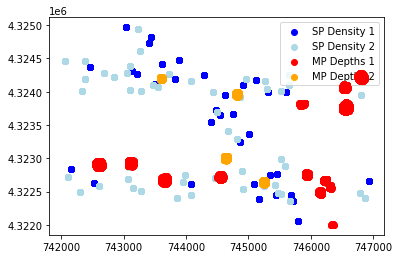

In [14]:
# Plot sites
plt.scatter(df_sp_gpr1['easting'], df_sp_gpr1['northing'], c = 'b', label = ('SP Density 1'))# {density1_date1} to {density1_date2}'))
plt.scatter(df_sp_gpr2['easting'], df_sp_gpr2['northing'], c = 'lightblue', label = ('SP Density 2'))# {density2_date1} to {density2_date2}'))
plt.scatter(df_mp_lidar1['easting'], df_mp_lidar1['northing'], c = 'red', zorder = 10, label = 'MP Depths 1')#+str(depth1_date1))
plt.scatter(df_mp_lidar2['easting'], df_mp_lidar2['northing'], c = 'orange', zorder = 1, label = 'MP Depths 2')#+str(depth2_date1))
plt.legend(loc = 'upper right')

For the interactive plots

In [15]:
# interactive plots
import holoviews as hv
import geoviews as gv
import hvplot.pandas
import hvplot.xarray
# set bokeh as the holoviews plotting backend
#hv.extension('bokeh')
# set holoviews backend to Bokeh
#gv.extension('bokeh')

In [17]:
CF_plot1 = df_mp_lidar1.hvplot(c= 'value', x='easting', y='northing',kind='points', alpha = 0.2, s= 0.25, color= 'red', crs = '26912')
CF_plot2 = df_mp_lidar2.hvplot(c= 'value', x='easting', y='northing',kind='points', alpha = 0.2, s= 0.25, color= 'blue', crs = '26912')
CF_plot3 = df_sp_gpr1.hvplot(c= 'value', x='easting', y='northing',kind='points', alpha = 0.2, s= 5, color= 'yellow', crs = '26912')
CF_plot4 = df_sp_gpr2.hvplot(c= 'value', x='easting', y='northing',kind='points', alpha = 0.2, s= 5, color= 'orange', crs = '26912')
CF_plot_comb = (CF_plot1 * CF_plot2 * CF_plot3 * CF_plot4)
CF_plot_comb
CF_plot_comb = CF_plot_comb.options(xlabel='Longitude', ylabel='Latitude', title='Combined Data')
CF_plot_comb

:Overlay
   .Points.I   :Points   [easting,northing]
   .Points.II  :Points   [easting,northing]
   .Points.III :Points   [easting,northing]
   .Points.IV  :Points   [easting,northing]

In [18]:
import colorcet as cc
from colorcet.plotting import swatch

swatch('CET_L6')

mag_cmap = cc.CET_L6[::-1]
swatch("CET_L6_r", mag_cmap)

:Image   [x,y]   (z)

In [19]:
from holoviews.element.tiles import EsriImagery
EsriImagery()

:Tiles   [x,y]

In [20]:
#Combined data overlaid on ESRI basemap

CF_plot_basemap = (EsriImagery() * CF_plot_comb)
CF_plot_basemap = CF_plot_basemap.options(xlabel='Longitude', ylabel='Latitude', title='Combined Data')
CF_plot_basemap



:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Points.I   :Points   [easting,northing]
   .Points.II  :Points   [easting,northing]
   .Points.III :Points   [easting,northing]
   .Points.IV  :Points   [easting,northing]

Possible to overlay a LiDAR raster on top of this map if desired

In [ ]:
#overlay raster and add to CF_plot_basemap with *
#GM_Lidar = cleaned_raster.hvplot.image(rasterize=True, cnorm='log', clim=(1, np.nan))
#GM_Lidar

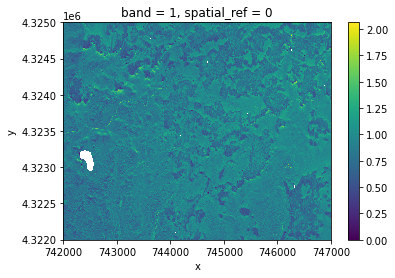

In [25]:
##ADD Lidar
# How to pull out ALL point data from the database that falls within our box
bbox_WSEN = 742000, 4322000, 747000, 4325000 # EPSG 26912?
x1, y1, x2, y2 = bbox_WSEN
polygon = shapely.geometry.Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]]) # used box() before
wkb_element = from_shape(polygon, srid=26912) # which srid is right?

query = session.query(func.ST_AsTiff(func.ST_Clip(func.ST_Union(ImageData.raster, type_=Raster), wkb_element)))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.filter(ImageData.date == "2020-02-02")

# Filter the query by bounding box
query = query.filter(gfunc.ST_Intersects(ImageData.raster, wkb_element))

result = query.all()
aso_2020_02_02_rio = raster_to_rasterio(session, result)[0]
aso_2020_02_02_raster = aso_2020_02_02_rio.read(1, masked=True)

# This part takes the `aso_2020_02_02_rio` object we get above and saves as a geoTIFF
filename = "aso_2020_02_02_raster.tif"
with rasterio.open(filename, 'w', **aso_2020_02_02_rio.profile) as f:
    f.write(aso_2020_02_02_rio.read(1), 1)
# Reopen in rioxarray
ASO_snow = rioxarray.open_rasterio(filename, masked=True)
ASO_snow.plot() # probably want to change this but shows the raster on correct coordinate grid

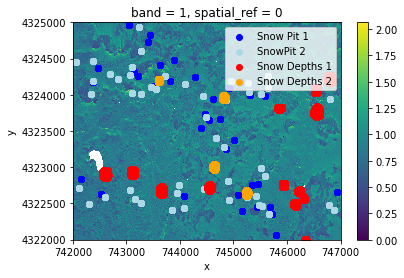

In [52]:
kwds = { 'label': "Density [kg/m3]", 'orientation': "horizontal"}
#Plot sites
ASO_snow.plot()
plt.scatter(df_sp_gpr1['easting'], df_sp_gpr1['northing'], c = 'b', label = ('Snow Pit 1'))# {density1_date1} to {density1_date2}'))
plt.scatter(df_sp_gpr2['easting'], df_sp_gpr2['northing'], c = 'lightblue', label = ('SnowPit 2'))# {density2_date1} to {density2_date2}'))
plt.scatter(df_mp_lidar1['easting'], df_mp_lidar1['northing'], c = 'red', zorder = 1, label = 'Snow Depths 1')#+str(depth1_date1))
plt.scatter(df_mp_lidar2['easting'], df_mp_lidar2['northing'], c = 'orange', zorder = 1, label = 'Snow Depths 2')#+str(depth2_date1))


plt.legend(loc = 'upper right')
plt.ticklabel_format(style='plain', useOffset=False)

plt.savefig('GPRLiDARstudysite.png', dpi=300, bbox_inches='tight')
